# CNN Regression

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.patches as mpatches


In [2]:
# Define the data path and batch size
data_path = 'data/embedded_padded'
BATCH_SIZE = 32

# Load datasets
train_dataset = torch.load(data_path + '/train.pt')
test_dataset = torch.load(data_path + '/test.pt')
val_dataset = torch.load(data_path + '/val.pt')

# Define the collate function for DataLoader
def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])  
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.float32).unsqueeze(1)  
    return input_ids, labels

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


/var/folders/l7/061cw0t95vz1myntpf9bj9540000gn/T/ipykernel_16242/2331049751.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(data_path + '/trai

/Users/michellegoppinger/Documents/Dokumente – Laptop von Michelle/Uni/Master/ANLP/ANLP_WS24_CA2/HumorDataset.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  item = {'input_ids': torch.tensor(self.data[idx], dtype=torch.float)}


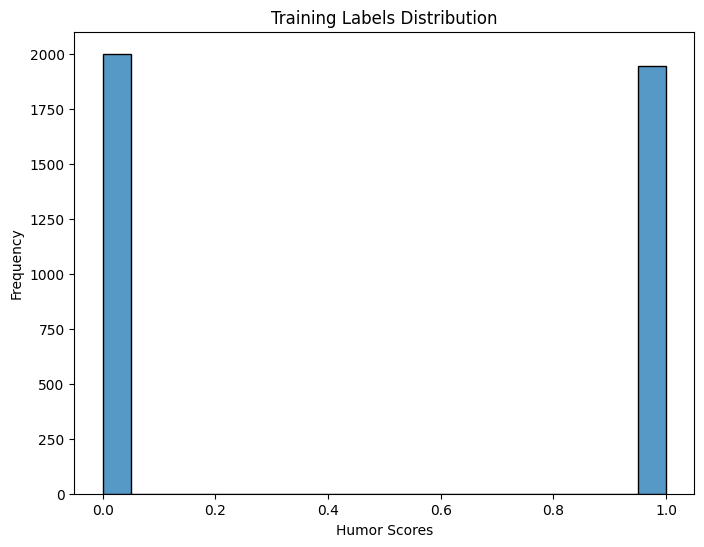

In [3]:
# Visualize label distribution in training data
train_labels = [item["labels"].item() for item in train_dataset]

plt.figure(figsize=(8, 6))
sns.histplot(train_labels, bins=20)
plt.xlabel("Humor Scores")
plt.ylabel("Frequency")
plt.title("Training Labels Distribution")
plt.show()


In [4]:
# Define the CNN model for regression
class CNN_HumorRegressor(nn.Module):
    def __init__(self, embed_dim, filter_sizes, num_filters, dropout=0.5):
        super(CNN_HumorRegressor, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embed_dim)) 
            for fs in filter_sizes
        ])
        self.highway = nn.Linear(len(filter_sizes) * num_filters, len(filter_sizes) * num_filters)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [Batch Size, 1, Seq Length, Embed Dim]
        conved = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conved]
        cat = torch.cat(pooled, dim=1)
        highway = F.relu(self.highway(cat))
        highway = self.dropout(highway + cat)
        fc_out = F.relu(self.fc1(highway))
        fc_out = F.relu(self.fc2(fc_out))
        return torch.sigmoid(self.fc3(fc_out))  # Sigmoid for range [0, 1]


In [5]:
# Define the weighted MSE loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, inputs, targets):
        weights = self.weights[targets.long()]
        loss = weights * (inputs - targets) ** 2
        return loss.mean()

# Define weights for loss function
weights = torch.tensor([2.0 if 0.2 <= x <= 0.8 else 1.0 for x in range(2)], dtype=torch.float32)


In [6]:
# Define the training function with ReduceLROnPlateau
def train_model_with_plateau_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, patience=3):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Training phase
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        val_loss, val_r2, val_mae = evaluate_with_metrics(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")
        print(f"Validation R²: {val_r2:.4f} | Validation MAE: {val_mae:.4f}")

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")  # Save best model
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # Load best model after training
    model.load_state_dict(torch.load("best_model.pt"))

# Evaluation function with metrics
def evaluate_with_metrics(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions, actuals = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    return avg_loss, r2, mae


In [7]:
# Hyperparameters
EMBED_DIM = train_dataset[0]["input_ids"].shape[1]
FILTER_SIZES = [2, 3, 4, 5]
NUM_FILTERS = 300
DROPOUT = 0.5
LR = 0.001
EPOCHS = 10

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, optimizer, and scheduler
model = CNN_HumorRegressor(EMBED_DIM, FILTER_SIZES, NUM_FILTERS, DROPOUT).to(device)
criterion = WeightedMSELoss(weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Train the model
train_model_with_plateau_scheduler(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS, device, patience=5)


/Users/michellegoppinger/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|██████████| 124/124 [00:31<00:00,  3.98batch/s, loss=0.22] 


Epoch 1/10 - Train Loss: 0.2443 - Val Loss: 0.2275
Validation R²: 0.0946 | Validation MAE: 0.4442


Epoch 2/10: 100%|██████████| 124/124 [00:30<00:00,  4.12batch/s, loss=0.267]


Epoch 2/10 - Train Loss: 0.2150 - Val Loss: 0.2126
Validation R²: 0.1520 | Validation MAE: 0.4143


Epoch 3/10: 100%|██████████| 124/124 [00:30<00:00,  4.13batch/s, loss=0.12] 


Epoch 3/10 - Train Loss: 0.1805 - Val Loss: 0.2393
Validation R²: 0.0442 | Validation MAE: 0.3811
No improvement for 1 epoch(s).


Epoch 4/10: 100%|██████████| 124/124 [00:30<00:00,  4.11batch/s, loss=0.119] 


Epoch 4/10 - Train Loss: 0.1306 - Val Loss: 0.2551
Validation R²: -0.0116 | Validation MAE: 0.3799
No improvement for 2 epoch(s).


Epoch 5/10: 100%|██████████| 124/124 [00:30<00:00,  4.08batch/s, loss=0.0157]


Epoch 5/10 - Train Loss: 0.0840 - Val Loss: 0.2769
Validation R²: -0.0851 | Validation MAE: 0.3798
No improvement for 3 epoch(s).


Epoch 6/10: 100%|██████████| 124/124 [00:30<00:00,  4.12batch/s, loss=0.00121]


Epoch 6/10 - Train Loss: 0.0412 - Val Loss: 0.2997
Validation R²: -0.1832 | Validation MAE: 0.3758
No improvement for 4 epoch(s).


Epoch 7/10: 100%|██████████| 124/124 [00:30<00:00,  4.12batch/s, loss=0.11]   


Epoch 7/10 - Train Loss: 0.0245 - Val Loss: 0.2891
Validation R²: -0.1477 | Validation MAE: 0.3619
No improvement for 5 epoch(s).
Early stopping triggered.


/var/folders/l7/061cw0t95vz1myntpf9bj9540000gn/T/ipykernel_16242/4163769425.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

In [8]:
# Evaluate the model on test set
test_loss, test_r2, test_mae = evaluate_with_metrics(model, test_loader, criterion, device)
print("Test Set Metrics:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Test Set Metrics:
Test Loss (MSE): 0.2196
Test R²: 0.1218
Test MAE: 0.4207
